In [1]:
'''
jupyter
opencv-python
matplotlib
labelme
'''

'\njupyter\nopencv-python\nmatplotlib\nlabelme\n'

In [2]:
'''
pip install torch==1.8.0+cpu torchvision==0.9.0+cpu torchaudio==0.8.0 -f https://download.pytorch.org/whl/torch_stable.html
'''

'\npip install torch==1.8.0+cpu torchvision==0.9.0+cpu torchaudio==0.8.0 -f https://download.pytorch.org/whl/torch_stable.html\n'

In [1]:
import os
import base64
import labelme
import cv2
import json
import numpy as np
import matplotlib.pyplot as plt

import torch
from segment_anything import sam_model_registry, SamPredictor

print(torch.__version__)

1.8.0+cpu


In [2]:
def show_mask(mask, ax, random_color=False):
    if random_color:
        color = np.concatenate([np.random.random(3), np.array([0.6])], axis=0)
    else:
        color = np.array([30/255, 144/255, 255/255, 0.6])
    h, w = mask.shape[-2:]
    mask_image = mask.reshape(h, w, 1) * color.reshape(1, 1, -1)
    ax.imshow(mask_image)
    
def show_points(coords, labels, ax, marker_size=375):
    pos_points = coords[labels==1]
    neg_points = coords[labels==0]
    ax.scatter(pos_points[:, 0], pos_points[:, 1], color='green', marker='*', s=marker_size, edgecolor='white', linewidth=1.25)
    ax.scatter(neg_points[:, 0], neg_points[:, 1], color='red', marker='*', s=marker_size, edgecolor='white', linewidth=1.25)   
    

In [3]:
print(os.listdir())
print(os.listdir('labelme_annotation_samples'))

['.ipynb_checkpoints', 'image_samples', 'labelme_annotation_samples', 'meta_seganything_ckpt', 'Object masks from prompts with SAM.ipynb', 'results', 'Untitled.ipynb']
['.ipynb_checkpoints', 'sample_halfblouse_1.PNG', 'sample_shorts_1.json', 'sample_shorts_1.PNG', 'sample_shortT_1.json', 'sample_shortT_1.PNG']


In [8]:
image_file = 'sample_halfblouse_1.PNG'
image_path = f'labelme_annotation_samples/{image_file}'
image = cv2.imread(image_path)
image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)

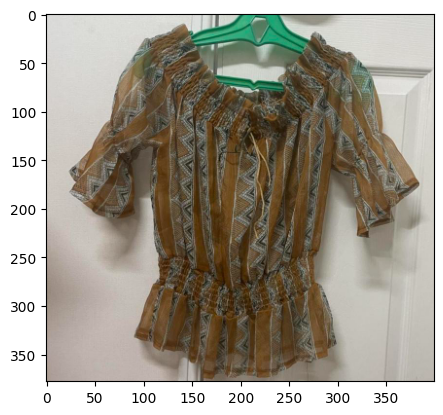

In [9]:
plt.figure(figsize=(5,5))
plt.imshow(image)
plt.axis('on')
plt.show()

In [81]:
clicked_points = []
clone = image.copy()
def MouseLeftClick(event, x, y, flags, param):
    if event == cv2.EVENT_LBUTTONDOWN:
        clicked_points.append((y, x))

        t_image = clone.copy()
        for point in clicked_points:
            cv2.circle(t_image, (point[1], point[0]), 4, (0, 255, 255), thickness = -1)
        cv2.imshow("image", t_image)

In [82]:
cv2.imshow('image', image)
cv2.setMouseCallback('image', MouseLeftClick)
cv2.waitKey(0)                                      
cv2.destroyAllWindows() 

print(clicked_points)

[(188, 199)]


In [12]:
print(os.listdir())
print(os.listdir('meta_seganything_ckpt'))

['.ipynb_checkpoints', 'image_samples', 'labelme_annotation_samples', 'meta_seganything_ckpt', 'Object masks from prompts with SAM.ipynb', 'results', 'Untitled.ipynb']
['.ipynb_checkpoints', 'sam_vit_b_01ec64.pth', 'sam_vit_h_4b8939.pth', 'sam_vit_l_0b3195.pth']


In [13]:
%%time

sam_checkpoint = "meta_seganything_ckpt/sam_vit_h_4b8939.pth"
model_type = "vit_h"

device = "cpu"

sam = sam_model_registry[model_type](checkpoint=sam_checkpoint)
sam.to(device=device)

predictor = SamPredictor(sam)

CPU times: total: 52.9 s
Wall time: 28.4 s


In [14]:
%%time

predictor.set_image(image)

In [17]:
input_point = np.array([[clicked_points[0][1], clicked_points[0][0]]])
input_label = np.array([1])

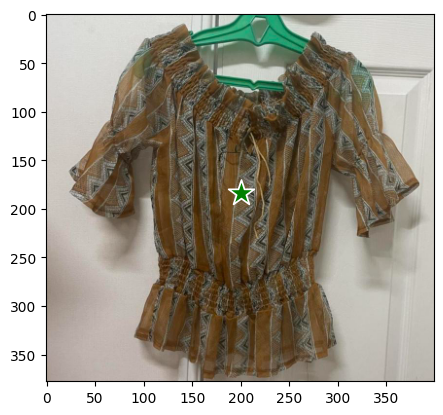

In [18]:
plt.figure(figsize=(5,5))
plt.imshow(image)
show_points(input_point, input_label, plt.gca())
plt.axis('on')
plt.show()  

In [19]:
masks, scores, logits = predictor.predict(
    point_coords=input_point,
    point_labels=input_label,
    multimask_output=True,
)

In [20]:
print(masks.shape)  # (number_of_masks) x H x W
max_idx = np.where(scores==max(scores))
print(scores, max_idx)

(3, 378, 399)
[0.82280433 1.0148562  0.96780336] (array([1], dtype=int64),)


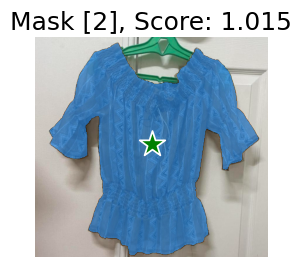

In [21]:
mask = masks[max_idx]
score = round(float(scores[max_idx]),3)

plt.figure(figsize=(3,3))
plt.imshow(image)
show_mask(mask, plt.gca())
show_points(input_point, input_label, plt.gca())
plt.title(f"Mask {max_idx[0]+1}, Score: {score:.3f}", fontsize=18)
plt.axis('off')
plt.show()  


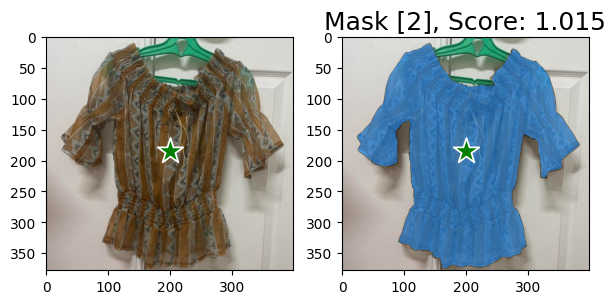

In [91]:
plt.figure(figsize=(7,7))
plt.subplot(1,2,1)
plt.imshow(image)
show_points(input_point, input_label, plt.gca())
plt.axis('on')
plt.subplot(1,2,2)
plt.title(f"Mask {max_idx[0]+1}, Score: {score:.3f}", fontsize=18)
plt.imshow(image)
show_mask(mask, plt.gca())
show_points(input_point, input_label, plt.gca())
plt.axis('on')
plt.show()  

(1, 378, 399)
[False  True]


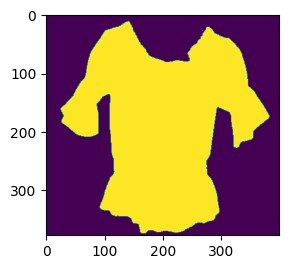

In [22]:
print(mask.shape)
print(np.unique(mask))
plt.figure(figsize=(3,3))
plt.imshow(mask[0])

In [23]:
contours, _ = cv2.findContours(mask[0].astype(np.uint8), cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
print(contours[0].shape)
contour_image = np.zeros_like(mask[0].astype(np.uint8), dtype=np.uint8)
cv2.drawContours(contour_image, contours, -1, (1), thickness=1)
object_edges = contour_image.astype(bool)
print(object_edges.shape)

(1, 1, 2)
(378, 399)


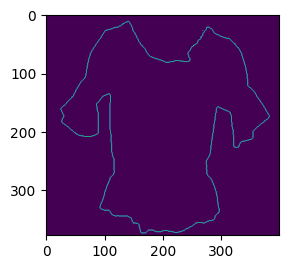

In [32]:
plt.figure(figsize=(3,3))
plt.imshow(object_edges)

In [36]:
len(contours)

2

In [50]:
all_contours = []
for i in contours :
    all_contours.extend(i.tolist())
all_contours = np.array(all_contours)
all_contours.shape

(665, 1, 2)

In [49]:
all_contours.shape

(665, 1, 2)

In [59]:
all_contours[2][0]

array([139,  13])

In [61]:
key = ['version', 'flags', 'shapes', 'imagePath', 'imageData', 'imageHeight', 'imageWidth']
result_json = {i:None for i in key}

result_json['version'] = '5.1.1'
result_json['flags'] = {}

# points =[]
# assert np.where(mask[0]==True)[0].shape == np.where(mask[0]==True)[1].shape
# for i in range(np.where(mask[0]==True)[0].shape[0]) :
#     points.append([float(seg_coord[0][i]), float(seg_coord[1][i])])
points =[]
for i in range(all_contours.shape[0]) :
    p = all_contours[i][0]
    points.append([float(p[0]), float(p[1])])
print(len(points))
shapes = [{'label': 'a','points':points,'group_id':None,'shape_type':'polygon','flags':{}}]
result_json['shapes'] = shapes

result_json['imagePath'] = image_file

encoded = labelme.LabelFile.load_image_file(image_path)
encoded = base64.b64encode(encoded).decode('utf-8')
result_json['imageData'] = encoded

result_json['imageHeight'] = int(image.shape[0])
result_json['imageWidth'] = int(image.shape[1])


665


In [80]:
with open('results/result1.json','w') as f:
    json.dump(result_json, f)
    
cv2.imwrite('results/result1.PNG', cv2.cvtColor(image, cv2.COLOR_RGB2BGR))

True

In [63]:
from pycocotools.coco import COCO
from pycocotools import mask as maskUtils

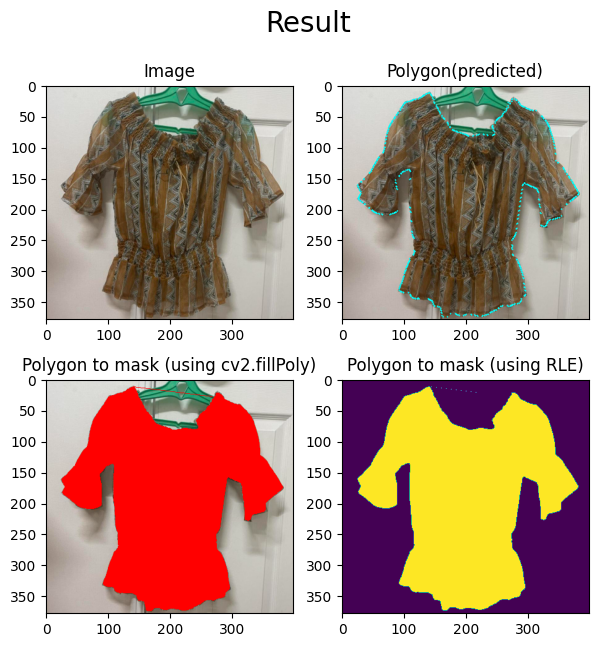

In [79]:
t_image = image.copy()

plt.figure(figsize=(7,7))
plt.subplot(2,2,1)
plt.title('Image')
plt.imshow(t_image)
for i in all_contours :
    coord = int(i[0][0]), int(i[0][1])
    t_image = cv2.circle(t_image, coord, 1, (0, 255, 255), -1)
    
plt.subplot(2,2,2)
plt.title('Polygon(predicted)')
plt.imshow(t_image)


t_image = image.copy()
t_image = cv2.fillPoly(t_image, pts=[all_contours], color=(255, 0, 0))

plt.subplot(2,2,3)
plt.title('Polygon to mask (using cv2.fillPoly)')
plt.imshow(t_image)

segm = [all_contours.flatten().tolist()]
rles = maskUtils.frPyObjects(segm, result_json['imageHeight'], result_json['imageWidth'])
rle = maskUtils.merge(rles)
m = maskUtils.decode(rle)

plt.subplot(2,2,4)
plt.title('Polygon to mask (using RLE)')
plt.imshow(m)

plt.suptitle('Result',size=20)
plt.show() 